In [1]:
import numpy as np
import tensorflow as tf
import gym
import math
import matplotlib.pyplot as plt

In [2]:
env = gym.make('CartPole-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
n_states = env.observation_space.shape[0]
STATE_BOUNDS = list(zip(env.observation_space.low, env.observation_space.high))
n_actions = env.action_space.n

In [4]:
STATE_BOUNDS

[(-4.8, 4.8),
 (-3.4028235e+38, 3.4028235e+38),
 (-0.41887903, 0.41887903),
 (-3.4028235e+38, 3.4028235e+38)]

In [5]:
STATE_BOUNDS[1] = (-1.,1.)
STATE_BOUNDS[3] = (-1.,1.)

In [6]:
def discretize(obs, bounds, bincount):
    s = np.zeros_like(obs, dtype='int')
    
    for i in range(len(obs)):
        s[i] = np.digitize(obs[i], np.linspace(bounds[i][0],bounds[i][1],bincount[i]))-1
        
    return tuple(s)

In [7]:
s_buckets = (30,30,30,30)
q_table = np.zeros(s_buckets + (n_actions,))

print("Q Table shape is {}".format(q_table.shape))

Q Table shape is (30, 30, 30, 30, 2)


In [8]:
from collections import deque

#--------------------------------
# Memory structure for storing past experience tuples
#--------------------------------
class Memory:
    def __init__(self, capacity=50):
        self.memories = deque()
        self.capacity = capacity
        self.n = len(self.memories)
    
    def forget(self):
        self.memories.popleft()
        self.n -= 1
    
    def remember(self, experience):
        self.memories.append(experience)
        self.n += 1
        if len(self.memories) > self.capacity:
            self.forget()
        
    def sample(self, n=1):
        idx = np.random.choice(range(len(self.memories)),n)
        return np.take(self.memories, idx, axis=0)

In [9]:
#--------------------------------
# Learning parameters
#--------------------------------
alpha = 0.9
dyna_alpha = 0.1
gamma = 0.99
epsilon = 1.0
decay = 0.998

alpha_min = 0.1
epsilon_min = 0.1

In [10]:
n_episodes = 1000
reward_history = []
experience_replay = Memory(capacity=5000)
hallucination_cnt = 20

#--------------------------------
# Iterate through pole balancing episodes
#--------------------------------
for episode in range(n_episodes):
    
    s = env.reset()
    rsum = 0
    explore_rate = max(epsilon_min, epsilon*decay**episode)
    
    #--------------------------------
    # individual steps through a single episode
    #--------------------------------
    while True:
        #--------------------------------
        # Epsilon greedy policy for selecting actions
        #--------------------------------
        sd = discretize(s,STATE_BOUNDS,s_buckets)
        a =  np.argmax(q_table[sd])
        if np.random.uniform() < explore_rate:
            a = np.random.choice(range(n_actions))
            
        #--------------------------------
        # Take selected action
        #--------------------------------            
        sp, r, d, _ = env.step(a)
        spd = discretize(sp,STATE_BOUNDS,s_buckets)
        
        #--------------------------------
        # hallucinate 
        #--------------------------------
        experience_replay.remember((sd,a,r,spd,d))
        if experience_replay.n > 100:
            for i in range(hallucination_cnt):
                h_sd, h_a, h_r, h_spd, h_d = experience_replay.sample()[0]
                if h_d:
                    q_table[h_sd + (h_a,)] = (1-dyna_alpha)*q_table[h_sd + (h_a,)] + dyna_alpha*(h_r)            
                else:        
                    q_table[h_sd + (h_a,)] = (1-dyna_alpha)*q_table[h_sd + (h_a,)] + dyna_alpha*(h_r + gamma*max(q_table[h_spd]))
                
        #--------------------------------
        # Update Q table with experience tuple
        #--------------------------------        
        if d:
            q_table[sd + (a,)] = (1-alpha)*q_table[sd + (a,)] + alpha*(r)            
        else:        
            q_table[sd + (a,)] = (1-alpha)*q_table[sd + (a,)] + alpha*(r + gamma*max(q_table[spd]))
        
        s = sp
        rsum += r
        if d:
            break

    reward_history.append(rsum)
    #--------------------------------
    # Print out progress indicators 
    #--------------------------------
    if episode%50==0:
        print("Episode {}: Avg Reward = {}, Exploration Rate = {:.3f}".format(episode,np.mean(reward_history[-50:]),explore_rate))

Episode 0: Avg Reward = 45.0, Exploration Rate = 1.000
Episode 50: Avg Reward = 19.8, Exploration Rate = 0.905
Episode 100: Avg Reward = 21.72, Exploration Rate = 0.819
Episode 150: Avg Reward = 22.02, Exploration Rate = 0.741
Episode 200: Avg Reward = 30.74, Exploration Rate = 0.670
Episode 250: Avg Reward = 32.22, Exploration Rate = 0.606
Episode 300: Avg Reward = 35.9, Exploration Rate = 0.548
Episode 350: Avg Reward = 33.3, Exploration Rate = 0.496
Episode 400: Avg Reward = 38.68, Exploration Rate = 0.449
Episode 450: Avg Reward = 55.12, Exploration Rate = 0.406
Episode 500: Avg Reward = 64.02, Exploration Rate = 0.368
Episode 550: Avg Reward = 77.88, Exploration Rate = 0.333
Episode 600: Avg Reward = 83.62, Exploration Rate = 0.301
Episode 650: Avg Reward = 102.9, Exploration Rate = 0.272
Episode 700: Avg Reward = 107.76, Exploration Rate = 0.246
Episode 750: Avg Reward = 123.4, Exploration Rate = 0.223
Episode 800: Avg Reward = 94.06, Exploration Rate = 0.202
Episode 850: Avg Rew

In [11]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

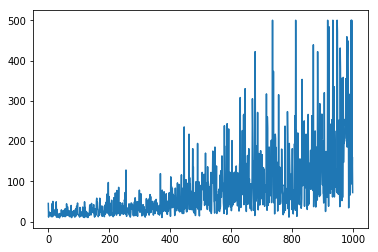

In [12]:
plt.plot(reward_history)

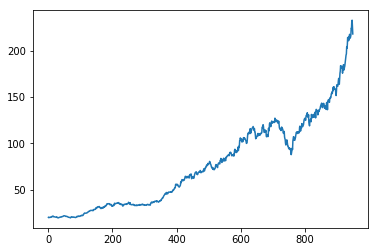

In [13]:
rmoving = running_mean(reward_history, 50)
plt.plot(rmoving)

---
## Run your trained agent for a random episode!

---

In [16]:
s = env.reset()
total_reward = 0
while True:
    sd = discretize(s,STATE_BOUNDS,s_buckets)
    a =  np.argmax(q_table[sd])

    sp, r, d, _ = env.step(a)
    env.render()

    total_reward += r
    s = sp
    if d:
        print(total_reward)
        break

500.0
